In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [7]:
def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSigFront(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(thermPulse(psi0, t1/3.0, Omega0, delPrime, eta, nbar0, Ncut), 2.0*t1/3.0, -Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [3]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

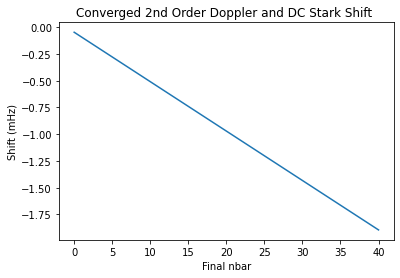

In [4]:
pts = 5
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shifts = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
plt.plot(nbarfs,shifts*nu0*1.0e3, label="Ncut=1201")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [32]:
def optimizeDelp(t1, T, delPrime0, eta, nbar0, nbarf, Ncut):
    t2 = t1/3.0
    Omega0 = np.pi/(2.0*t2)
    psi0 = psi(0.0,1.0)
    x0 = -0.1
    x1 = 0.1
    shift =sp.optimize.root_scalar(HRJumpThermErrSigFront, args=(psi0, t1, T, t2, delPrime0, Omega0, eta, 0.0, nbarf, Ncut), bracket=[x0,x1], xtol = 1e-10).root
    dopStark = -nu0*expEHeat(nbar0, nbarf, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
    return delPrime0*(dopStark/shift)

In [33]:
optimizeDelp(60e-3, 500e-3, 0.27*2.0*np.pi, 0.05, 0.0, 30.0, 401)

1.610268058411276

In [36]:
Ncut = 401
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
delPrime = 0.25628*2.0*np.pi #hz
t2 = 20.0e-3
t1 = 3.0*t1
Omega0 = np.pi/(2.0*t2) #hz
T = 500.0e-3
eta = 0.05
#shifts1 = np.zeros(pts)
shifts4 = np.zeros(pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts4[ii] = sp.optimize.root_scalar(HRJumpThermErrSigFront, args=(psi0, t1, T, t2, delPrime, Omega0, eta, 0.0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts4[ii])
    x0 = shifts4[ii] - guessTol
    x1 = shifts4[ii] + guessTol
    #print(x0,x1)

0.0
6.9121996900227e-05
10.0
-0.000484559763518324
20.0
-0.0009858359562556116
30.0
-0.0014404487154438877
40.0
-0.001853118074442694


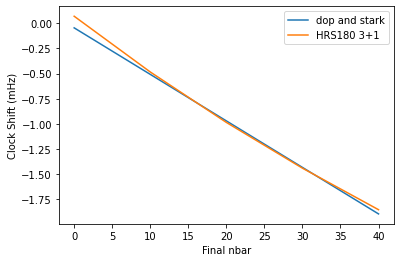

In [37]:
plt.plot(nbarfs,shifts*nu0*1.0e3, label="dop and stark")
#plt.plot(nbarfs, shifts1*1e3, label="HRS180 1+3")
plt.plot(nbarfs, shifts4*1e3, label="HRS180 3+1")

plt.xlabel("Final nbar")
plt.ylabel("Clock Shift (mHz)")
plt.legend()
plt.show()

Text(0.5, 0, 'Final nbar')

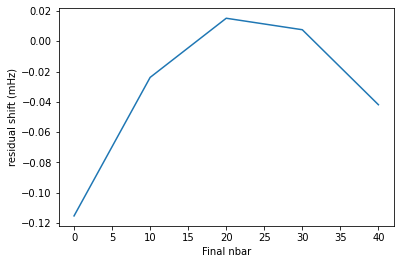

In [38]:
plt.plot(nbarfs, (shifts*nu0-shifts4)*1e3)
plt.ylabel("residual shift (mHz)")
plt.xlabel("Final nbar")

Text(0, 0.5, '% error')

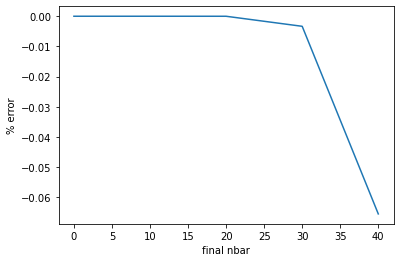

In [26]:
plt.plot(nbarfs, (shifts1-shifts2)/shifts1*100)
plt.xlabel("final nbar")
plt.ylabel("% error")

In [35]:
1.610268058411276/(2*np.pi)

0.25628212119914345